# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

Percentage of the total variance explained by k principal components
K = 1 Percent variance explained = 16.40%
K = 2 Percent variance explained = 13.32%
K = 3 Percent variance explained = 10.17%
K = 4 Percent variance explained = 7.06%
K = 5 Percent variance explained = 3.87%
K = 6 Percent variance explained = 3.68%
K = 7 Percent variance explained = 3.13%
K = 8 Percent variance explained = 2.73%
K = 9 Percent variance explained = 2.62%
K = 10 Percent variance explained = 2.23%
K = 11 Percent variance explained = 2.05%
K = 12 Percent variance explained = 1.87%
K = 13 Percent variance explained = 1.73%
K = 14 Percent variance explained = 1.68%
K = 15 Percent variance explained = 1.52%
K = 16 Percent variance explained = 1.51%
K = 17 Percent variance explained = 1.43%
K = 18 Percent variance explained = 1.41%
K = 19 Percent variance explained = 1.33%
K = 20 Percent variance explained = 1.15%
K = 21 Percent variance explained = 1.07%
K = 22 Percent variance explained = 1.07%
K = 23 Percen

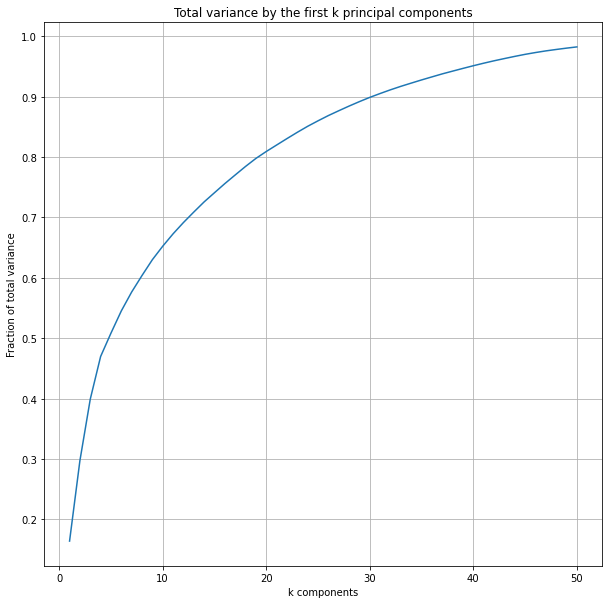

In [5]:
def P1():
    ## STUDENT START ###
        
    #pca model and fitting it to the train_data
    #n_components to 50
    #explained variance ratio
    pca = PCA(n_components=50)
    pca_fit = pca.fit(train_data)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    print("Percentage of the total variance explained by k principal components")
    print("====================================================================")
    
    #Using a lambda function to calculate the percentage of total variance for each k
    list(map(lambda k: print('K = %d Percent variance explained = %.2f%%' %(k+1,
        round(pca.explained_variance_ratio_[k],4)*100)),range(50)))

    
    #plotting the results.
    plt.figure(figsize=(10,10)) 
    plt.plot(list(range(1,51)),[sum(pca.explained_variance_ratio_[:k]) for k in range(1,51)])
    plt.ylabel('Fraction of total variance') 
    plt.xlabel('k components')
    plt.title('Total variance by the first k principal components')
    plt.grid()
    plt.show() 
    
    ## STUDENT END ###

P1()

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

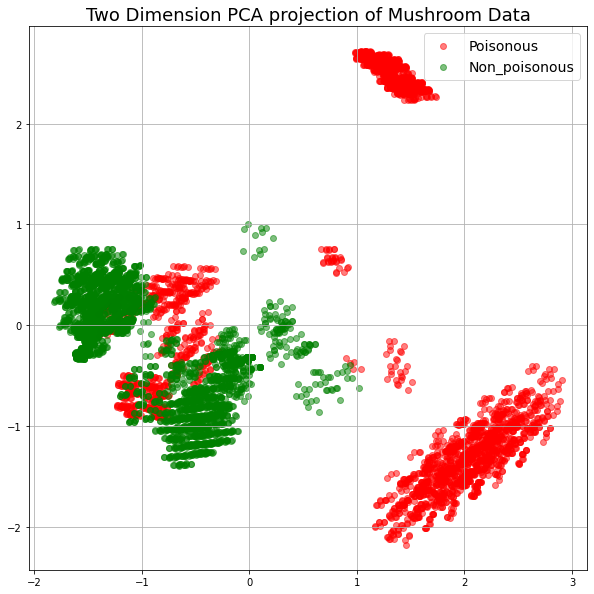

In [6]:
def Q2():
    
### STUDENT START ###
    
    # Fit PCA
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(train_data)

    # Plotting
    fig, ax = plt.subplots(figsize=(10,10))
    
    #scatter plot of poinonous vs non-poinonous data points based on labels
    ax.scatter(pca_fit[train_labels==1, 0], pca_fit[train_labels==1, 1],
               label='Poisonous', color='red', alpha = 0.5)
    
    ax.scatter(pca_fit[train_labels==0, 0], pca_fit[train_labels==0, 1],
               label='Non_poisonous', color='green', alpha=0.5)
    
    ax.legend(fontsize=14)
    ax.set_title('Two Dimension PCA projection of Mushroom Data', fontsize=18)
    plt.grid()

    plt.show()

### STUDENT END ###

Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

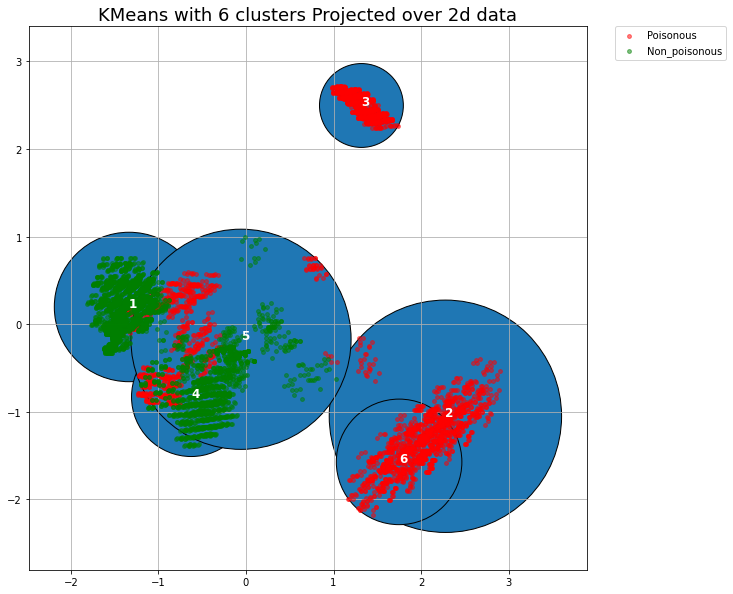

In [7]:
from scipy.spatial.distance import cdist

def Q3():   
  ### STUDENT START ###

    #fitting PCA training
    pca=PCA(n_components=2)
    pca_fit=np.array(pca.fit_transform(train_data))
    
    #Kmeans cluster model with 6 clusters over the 2d projected Data
    kmeans=KMeans(n_clusters=6,random_state=0)
    kmeans.fit(pca_fit)
    
    
    #plotting
    plt.figure(figsize=(10,10))
    ax=plt.gca()
    ax.axis('equal')
    ax.scatter(pca_fit[train_labels==1, 0], pca_fit[train_labels==1, 1],
               label='Poisonous', color='red', alpha = 0.5, s =15, zorder=2)
    
    ax.scatter(pca_fit[train_labels==0, 0], pca_fit[train_labels==0, 1],
               label='Non_poisonous', color='green', alpha=0.5,s =15, zorder=2)
    
    #finding the center of centroids for each cluster
    for i in range(6):
        radius = cdist(pca_fit[kmeans.labels_ == i], [kmeans.cluster_centers_[i]]).max()
        circle=plt.Circle(kmeans.cluster_centers_[i], radius, ec = "black")
        ax.add_patch(circle)
        plt.text(kmeans.cluster_centers_[i][0],kmeans.cluster_centers_[i][1],str(i+1),color='white',size=12,weight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('KMeans with 6 clusters Projected over 2d data', fontsize = 18)
    plt.grid()
    plt.show()
  ### STUDENT END ###

Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

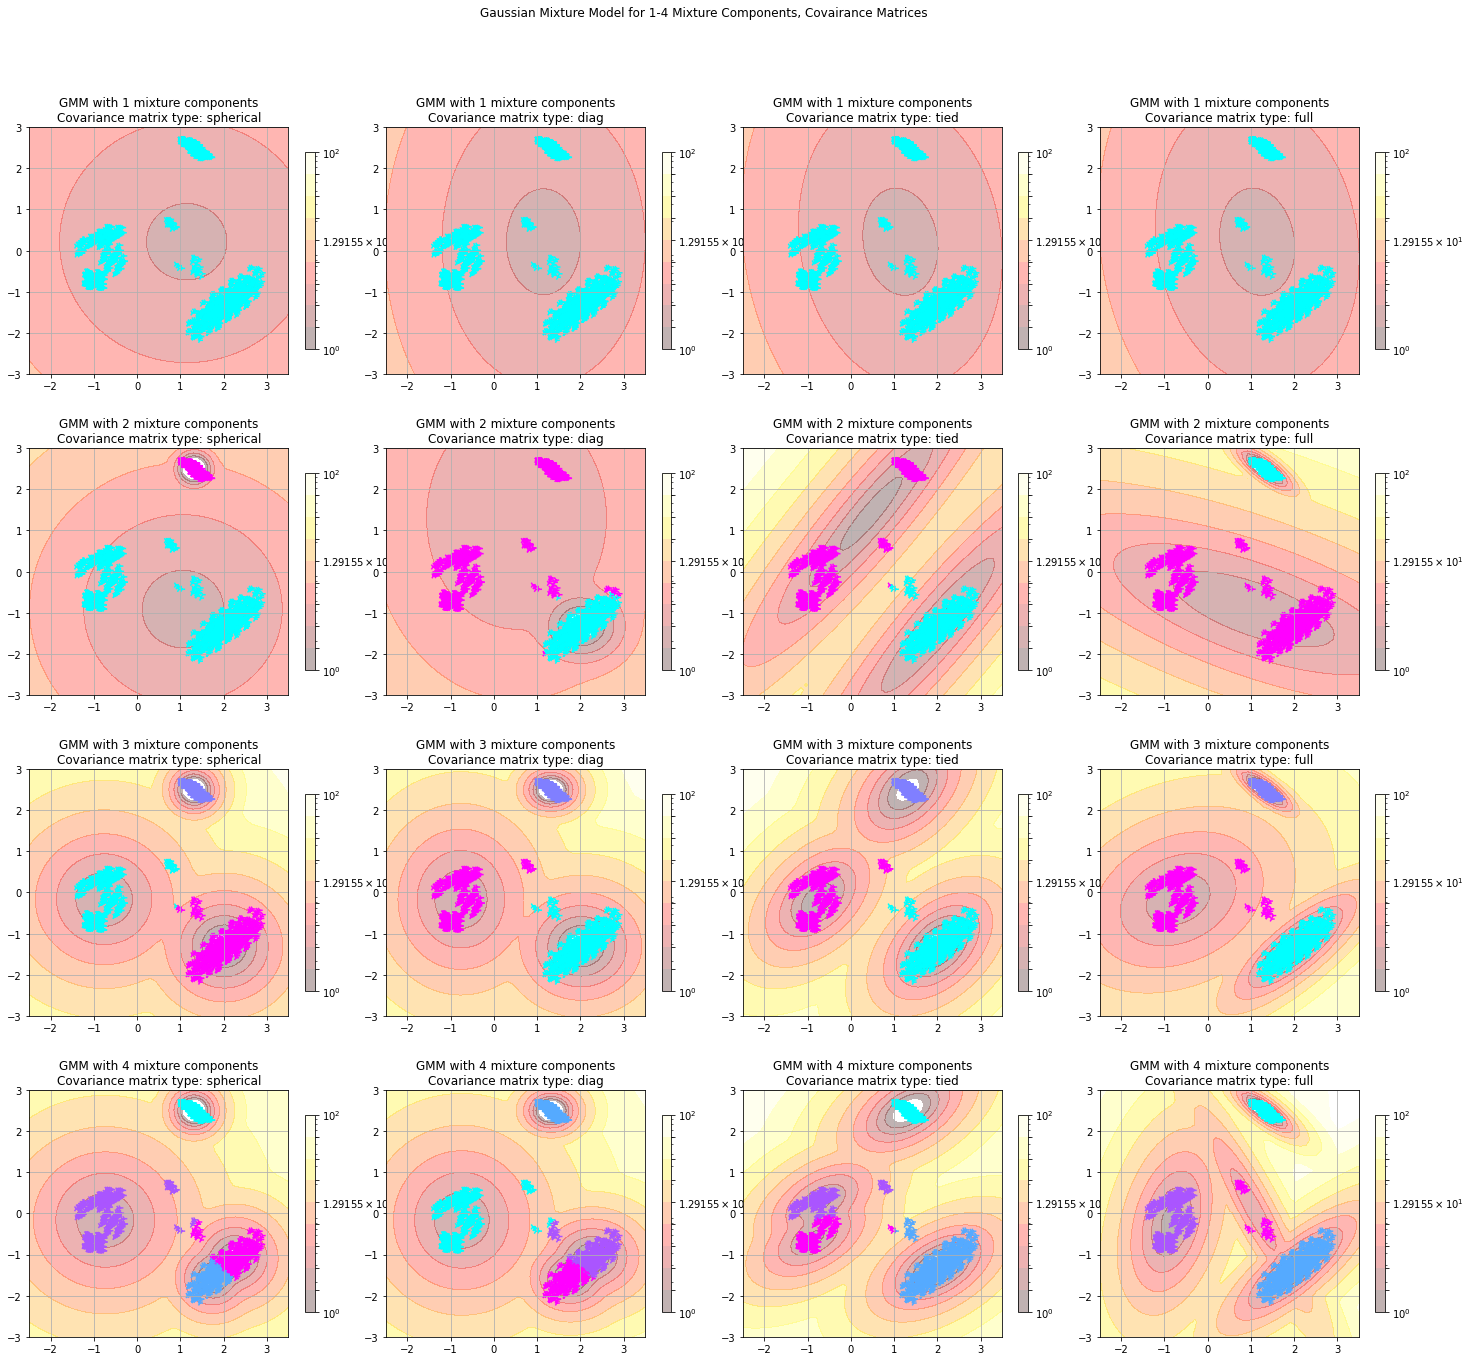

In [8]:
from sklearn import mixture
import warnings 
warnings.filterwarnings('ignore')
def Q4():
    ### STUDENT START ###
    
    #fitting PCA and choosing poisonous labels
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(train_data)[train_labels == 1]
    
    #starting a count 
    count = 1
    
    #plot
    fig = plt.figure()
    fig.set_size_inches(25,21)
    fig.suptitle("Gaussian Mixture Model for 1-4 Mixture Components, Covairance Matrices")
    
    #4 covariance matrix
    covariance_matrix_type = ['spherical', 'diag', 'tied', 'full']
    
    plt.subplots_adjust(left=0.125, bottom= 0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.3)
    
    #looping through the 4 mixture components 
    for i in range(1,5):
        #looping through array of covariance matrix types
        for j in covariance_matrix_type:
            gmm = GaussianMixture(n_components = i, covariance_type = j)
            gmm.fit(pca_fit)
            
            pred = gmm.predict(pca_fit)
            
            # Plotting contours. 
            x = np.linspace(-2.5, 3.5) #set limits of x
            y = np.linspace(-3., 3.) #set limits of y
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)
    
            #adding to the grid
            ax = fig.add_subplot(4, 4, count)
            #add to count
            count = count + 1
            
            CS = plt.contourf(X, Y, Z,norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 2, 10), alpha=.3, cmap='hot')
            
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            
            plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=pred, marker="4",  cmap='cool') 
            plt.title("GMM with " + str(i) + " mixture components\nCovariance matrix type: " + j)
            plt.grid()
            plt.axis('tight')

    
    ### STUDENT END ###
    
Q4()

Answer: `full` means that the components may independently adopt any position and shape. `Tied` means they have the same shape, but the shape may be anything. We can see this behavior in the plots above. 



### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def Q5(): 
    
  ### STUDENT START ###

    #transforming both train and test data
    pca = PCA(n_components=2)
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)

    # Getting poisonous and nonpoisonous data point from training data
    pca_poison = pca_train[train_labels == 1]
    pca_nonpoison = pca_train[train_labels == 0]

    # fitting GMM models to poison and non poison sets
    #finding score samples for both 
    gmm = GaussianMixture(n_components=4, covariance_type='full')
    gmm_poison = gmm.fit(pca_poison)
    poison_score_sample = gmm_poison.score_samples(pca_test)
    
    gmm_nonpoison = gmm.fit(pca_nonpoison)
    nonpoison_score_sampel = gmm_nonpoison.score_samples(pca_test)
    
    
    # predicting the more likely label 1 or 0
    pred_labels = poison_score_sample > nonpoison_score_sampel

    # calculatin accuracy
    accuracy = float(np.sum(test_labels==pred_labels))/len(test_labels)
    print(f'The accuray is {accuracy}')


  ### STUDENT END ###

Q5()

The accuray is 0.9501779359430605


### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.

Finding the best combination of PCA Components, Mixture Components, Covariance Matrix Type


,PCA_Components,GMM_Mixture_Components,Covariance_Matrix_type,N_Parameters,Accuracy
132,13,1,tied,50.0,0.992883
104,5,2,full,38.0,0.991993
99,5,1,tied,18.0,0.991993
105,5,3,spherical,48.0,0.991993
97,5,1,spherical,28.0,0.991993
...,...,...,...,...,...
28,1,9,spherical,20.0,0.906584
27,1,8,diag,32.0,0.906584
26,1,8,spherical,18.0,0.906584
25,1,7,diag,28.0,0.906584


The combination of parameters that resulted in the best accuracy is:
Best number of PCA components: 13
Best number of GMM components: 1
Covariance Type: tied
Max Accuracy: 0.9928825622775801


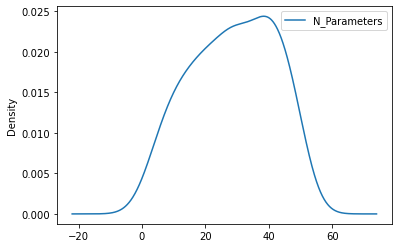

In [10]:
from matplotlib.lines import Line2D

def Q6():
  ### STUDENT START ###

    ##############defining a function to count the parameters based on different scenarios##############
    def parameter_count(covariance_type, n_classes, n_components, n_dimensions):
        if covariance_type == "spherical":
            mean_params = n_components * n_dimensions
            covariance_params = n_components * 1
            component_weights = n_components - 1
            return n_classes * (mean_params + covariance_params + component_weights)
        elif covariance_type == "diag":
            mean_params = n_components * n_dimensions
            covariance_params = n_components * n_dimensions
            component_weights = n_components - 1
            return n_classes * (mean_params + covariance_params + component_weights)
            pass
        elif  covariance_type == "tied":
            mean_params = n_components * n_dimensions
            covariance_params = (n_dimensions * (n_dimensions - 1) / 2)
            component_weights = n_components - 1
            return n_classes * (mean_params + covariance_params + component_weights)
        elif covariance_type == "full":
            mean_params = n_components * n_dimensions
            covariance_params = n_components * (n_dimensions * (n_dimensions - 1) / 2)
            component_weights = n_components - 1
            return n_classes * (mean_params + covariance_params + component_weights)
            raise Exception(f"Unknown covariance type {covariance_type}")
    
    
    ################I will be using my code line from question 5 to make it easier to find accuracy####### 
    
    def gmm_accuracy(pca_components, mixture_components, covariance_mixture_type):
        pca = PCA(n_components=pca_components)
        pca_train = pca.fit_transform(train_data)
        pca_test = pca.transform(test_data)

        # Getting poisonous and nonpoisonous data point from training data
        pca_poison = pca_train[train_labels == 1]
        pca_nonpoison = pca_train[train_labels == 0]

        # fitting GMM models to poison and non poison sets
        #finding score samples for both 
        gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=1234)
        gmm_poison = gmm.fit(pca_poison)
        poison_score_sample = gmm_poison.score_samples(pca_test)

        gmm_nonpoison = gmm.fit(pca_nonpoison)
        nonpoison_score_sampel = gmm_nonpoison.score_samples(pca_test)


        # predicting the more likely label 1 or 0
        pred_labels = poison_score_sample > nonpoison_score_sampel

        # calculatin accuracy
        accuracy = float(np.sum(test_labels==pred_labels))/len(test_labels)
        #print(f'The accuray is {accuracy}')
        
        return accuracy
    
    #covariance matrix types
    covariance_matrix_types = ['spherical', 'diag', 'tied', 'full']
    
    #initializing some variabels
    best_pca_component = 0
    best_mixture_component = 0
    best_covariance_type = 0
    max_accuracy = 0
    
    #initiazlizing some list
    number_components_array = []
    pca_components_array = []
    mixture_components_array =  []
    covariance_matrix_type_array = []
    accuracy_array = []
    #number of PCA testing through 20
    for i in range(1,20): 
        #number of GMM mixture component, testing through 20
        for j in range(1,20): 
            #iterating through different covariant matrix types
            for k in covariance_matrix_types:
                #the result should be equal to or below 50 parameters
                #recalling the function to count the number of parameters
                num_parameters = parameter_count(k, 2, i, j)
                
                #if results are below 50 parameters then find the accuracy by recalling the gmm_accuracy formula
                #append the values to appropriate lists
                if num_parameters <= 50: 
                    current_accuracy = gmm_accuracy(i, j, k)
                    pca_components_array.append(i)
                    mixture_components_array.append(j)
                    covariance_matrix_type_array.append(k)
                    accuracy_array.append(current_accuracy)
                    number_components_array.append(num_parameters)
                    if current_accuracy > max_accuracy:
                        max_accuracy = current_accuracy
                        best_pca_components = i
                        best_mixture_components = j
                        best_covariance_type = k
                    else:
                        continue
                else:
                    continue
    
    #converting the list to dataframe. 
    #global df
    df = pd.DataFrame({"PCA_Components": pca_components_array, 
                         "GMM_Mixture_Components":mixture_components_array,
                         "Covariance_Matrix_type": covariance_matrix_type_array, 
                         "N_Parameters": number_components_array,
                         "Accuracy":accuracy_array,
                     })


    print("Finding the best combination of PCA Components, Mixture Components, Covariance Matrix Type")
    print("===========================================================================================")
    #sort df by highest accuracy value
    display(df.sort_values(by=['Accuracy'], ascending = False)) 

    print("The combination of parameters that resulted in the best accuracy is:")
    print("====================================================================")
    print("Best number of PCA components: " + str(best_pca_components))
    print("Best number of GMM components: " + str(best_mixture_components))
    print("Covariance Type: " + str(best_covariance_type))
    print("Max Accuracy: " + str(max_accuracy))

    #graph of accuracy vs number of parameters
    df.groupby("N_Parameters")
    df.plot.density(x='Accuracy', y= "N_Parameters")
  ### STUDENT END ###

Q6()
